In [ ]:
class IoULoss(nn.Module) :
    def __init__(self, method = 'IoU') :
        super().__init__()
        self.method = method

    def forward(self, inp, target) :
        '''
        input : (B, # of bboxes, 6)
        '''
        inp_w = inp[..., 2:3]
        inp_h = inp[..., 3:4]
        target_w = target[..., 2:3]
        target_h = target[..., 3:4]

        inp_area = inp_w * inp_h
        target_area = target_w * target_h

        inp_xmin = inp[..., 0:1] - inp_w / 2
        inp_ymin = inp[..., 1:2] - inp_h / 2
        inp_xmax = inp[..., 0:1] + inp_w / 2
        inp_ymax = inp[..., 1:2] + inp_w / 2

        target_xmin = target[..., 0:1] - target_w / 2
        target_ymin = target[..., 1:2] - target_h / 2
        target_xmax = target[..., 0:1] + target_w / 2
        target_ymax = target[..., 1:2] + target_w / 2
        
        inp_topleft = torch.cat([inp_xmin, inp_ymin], axis = -1)
        target_topleft = torch.cat([target_xmin, target_ymin], axis = -1)

        inp_bottomright = torch.cat([inp_xmax, inp_ymax], axis = -1)
        target_bottomright = torch.cat([target_xmax, target_ymax], axis = -1)

        intersection_top_left = torch.max(inp_topleft, target_topleft)
        intersection_bottom_right = torch.min(inp_bottomright, target_bottomright)



        area_inter = torch.prod(
            torch.clip(intersection_bottom_right - intersection_top_left, min = 0 , max = None), -1).unsqueeze(-1)

        iou = area_inter / (inp_area + target_area - area_inter + 1e-9)

        # GIoU : IoU - |C \ (A U B)| over C. C는 bbox와 GT를 모두 포함하는 최소 크기의 박스.
        C_top_left = torch.min(inp_topleft, target_topleft)
        C_bottom_right = torch.max(inp_bottomright, target_bottomright)
        C_area = torch.prod(C_bottom_right - C_top_left, -1).unsqueeze(-1)

        # DIoU : 중심좌표 반영. 1 - IoU + euclidean(pred_center, gt_center) / (diagonal length of C)**2 . C는 bbox와 GT를 모두 포함하는 최소 크기의 박스.
        euclidean = torch.sqrt(torch.sum((inp[..., 0:2] - target[..., 0:2]) ** 2, dim = -1)).unsqueeze(-1)
        diagonal_length_C = torch.sum((C_bottom_right - C_top_left) ** 2, dim = -1).unsqueeze(-1)

        # CIoU : overlap area, central point distance, aspect ratio 고려. 
        # 1 - IoU + 1 - IoU + euclidean(pred_center, gt_center) / (diagonal length of C)**2 + aspect_ratio_resemblance * alpha
        # aspect_ratio_resemblance = 4 / pi**2 (arctan(w_gt/h_gt) - arctan(w_pred/h_pred)) ** 2. 
        # (4/pi**2) * (arctan(w/h)) range from -0.5 to 0.5
        # alpha = positive trade-off parameter. aspect_ratio_resemblance / (1-IoU) + aspect_ratio_resemblance. IoU가 클수록 aspect_ratio_resemblance의 영향력을 키운다.
        aspect_ratio_resemblance = (4 / torch.pi ** 2) * (torch.atan(target_w / target_h) - torch.atan(inp_w / inp_h)) ** 2
        alpha = aspect_ratio_resemblance / ( (1 - iou) + aspect_ratio_resemblance)

        if self.method == 'IoU' : 
            return 1 - iou
        elif self.method == 'GIoU' :
            return 1 - (iou - (C_area - (inp_area + target_area - area_inter)) / C_area)
        elif self.method == 'DIoU' :
            return 1 - iou + (euclidean / diagonal_length_C)
        elif self.method == 'CIoU' :
            return 1 - iou + (euclidean / diagonal_length_C) + alpha * aspect_ratio_resemblance

In [ ]:
# test case 1. IoU 0.36
# test case 2. IoU 1.
# test case 3. IoU 0
# test case 4. IoU 0
pred = torch.tensor([[0.5, 0.5, 0.5, 0.5],
                     [0.5, 0.5, 0.3, 0.3],
                     [0.1, 0.3, 0.2, 0.2],
                     [0.1, 0.3, 0.2, 0.2]
                ]).unsqueeze(0) # for batch

gt = torch.tensor([[0.7, 0.7, 0.4, 0.4],
                   [0.5, 0.5, 0.3, 0.3],
                   [0.6, 0.3, 0.2, 0.2],
                   [0.3, 0.3, 0.2, 0.2]
                ]).unsqueeze(0) # for batch

pred = torch.randn(16, 3, 13, 13, 4)
gt = torch.randn(16, 3, 13, 13, 4)


In [ ]:
iouloss = IoULoss(method = 'CIoU')

In [ ]:
iouloss(pred, gt).shape

In [ ]:
0.0625 / (0.25 + 0.16 - 0.0625)

In [ ]:
torch.pi

In [ ]:
torch.atan(torch.tensor([1/6 * torch.pi]))

In [ ]:
2 **(1/2) / 2

In [ ]:
# k = {1, 5, 9, 13}
# dilated convolution
# kernel size 3: dilated ratio equals to k, max-pooling of stride 1, 
k = 5
dilated_conv = torch.nn.Conv2d(3, 64, kernel_size = 3, stride = 1, padding = 1, dilation= k)

batch_size = 4

inp = torch.randn(batch_size, 3, 256, 256)

dilated_conv(inp).shape

In [ ]:
bn = nn.BatchNorm2d(32)
samp = torch.randn((1, 32, 64, 64))

bn(samp).shape

In [ ]:
bn.eps

In [ ]:
class ChannelPool(nn.Module):
    def forward(self, x):
        return torch.cat( (torch.max(x,1)[0].unsqueeze(1), torch.mean(x,1).unsqueeze(1)), dim=1 )


In [ ]:
import torch
import torch.nn as nn
import numpy as np

In [ ]:
conv = baseblock.conv[0]

conv.bias.fill_(0)

In [ ]:
baseblock = BaseBlock(3, 64, 3, 1, 1)
baseblock(torch.randn(1,3,24,24)).shape

In [ ]:
class BaseBlock(nn.Module) :
    def __init__(self, in_channels, out_channels, kernel_size, stride = 1, padding = 0, act_fn = 'mish') :
        super().__init__()
        if act_fn.lower() == 'mish' :
            activation = nn.Mish()
        elif act_fn.lower() == 'leakyrelu' :
            activation = nn.LeakyReLU()
        elif act_fn.lower() == 'relu' :
            activation = nn.ReLU()
        else :
            raise ValueError(f'{act_fn} activation function is not covered. add on DarkNetBottleneck module.')

        self.activation = activation
        self.conv = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = kernel_size, stride = stride, padding = padding),
                        nn.BatchNorm2d(out_channels),
                        self.activation)
                        
    def forward(self, x) :
        return self.conv(x)
        

class DarkNetBottleneck(nn.Module) :
    def __init__(self, in_channels, out_channels, expansion = 2, act_fn = 'mish') :
        super().__init__()

        mid_channels = int(out_channels / expansion)
        ## Depthwise separable Block
        self.conv1 = BaseBlock(in_channels, mid_channels, act_fn = act_fn, kernel_size = 1, stride = 1, padding = 0)
        self.conv2 = BaseBlock(mid_channels, out_channels, act_fn = act_fn, kernel_size = 3, stride = 1, padding = 1)

    def forward(self, x) :
        residual = x
        output = self.conv1(x)
        output = self.conv2(output)
        output += residual

        return output

In [ ]:
class CSPStage(nn.Module) : 
    def __init__(self, in_channels, mid_channels, out_channels, block_fn, expansion, act_fn, num_blocks) :
        '''
        input x will be channel-wise splited into part1 and part2.
        During CSP, only part2 will go through block_fn.
        downsampling layer before CSP, and transition after concatenation.
        input x : (B, C, H, W)
        part1&part2 : (B, C // 2, H, W)
        C should be divisible by 2.

        in_channels : input channel of downsample layer. downsample layer reduce the feature size by 2
        mid_channels : output channel of downsample layer and input channel of cspblock
        block_fn : block function that will be applied on part2. For Darknet53, we are going to use DarkNetBottleneck.
        expansion : expansion of block_fn. e.g) expansion=2, C_in -> C_out//2 -> C_out. C means channel.
        act_fn : activation function. For DarkNet53, we are going to use mish.
        num_blocks : number of iterations of block_fn
        '''
        super().__init__()
        self.downsample = BaseBlock(in_channels, mid_channels, kernel_size = 3, stride = 2, padding = 1)
        self.cspblock = nn.Sequential()

        block_channels = mid_channels // 2 # input_channel for part2

        for i in range(num_blocks) :

            block = block_fn(in_channels = block_channels, 
                                             out_channels = block_channels,
                                             expansion = expansion,
                                             act_fn = act_fn
                                             ) # this only covers DarkNetBottleneck module.

            self.cspblock.add_module(f'partial_block_{i+1}', block )
            
        self.after_cspblock = BaseBlock(in_channels = block_channels, 
                                        out_channels = block_channels,
                                        kernel_size = 1,
                                        stride = 1,
                                        padding = 0,
                                        )
        
        self.transition = BaseBlock(in_channels = 2 * block_channels, 
                                        out_channels = out_channels,
                                        kernel_size = 1,
                                        stride = 1,
                                        padding = 0,
                                        )


    def forward(self, x) :
        x = self.downsample(x)
        split = x.shape[1] // 2
        part1, part2 = x[:, :split], x[:, split:]

        part2 = self.cspblock(part2)
        part2 = self.after_cspblock(part2).contiguous()

        output = torch.cat([part1, part2], dim = 1)
        output = self.transition(output)

        return output


In [ ]:
modules = nn.ModuleList()

modules.add_module('abc', nn.Conv2d(3,6,3,1,1,1))

for m in modules :
    print(m)

In [ ]:
class DarkNet53(nn.Module) :
    '''
    initial layer : conv(3,3,32)/1, mish

    in_channels  : [3, 32,  64,  64, 128,  256]
    mid_channels : [64, 128, 256, 512, 1024]
    out_channels : [64,  64, 128, 256,  512]

    num_blocks of cspstage : [1,2,8,8,4]
    '''
    def __init__(self, act_fn, block_fn, expansion, in_channels_list = [], mid_channels_list = [], out_channels_list = [], num_blocks_list = []) :
        super().__init__()
        
        self.input_layer = BaseBlock(in_channels_list[0], in_channels_list[1], kernel_size = 3, stride = 1, padding = 1)
        
        self.modulelist = nn.Sequential()
        for i, num_blocks in enumerate(num_blocks_list) :
            
            cspstage = CSPStage(in_channels = in_channels_list[i+1], 
                            mid_channels = mid_channels_list[i], 
                            out_channels = out_channels_list[i], 
                            block_fn = block_fn, 
                            expansion = expansion, 
                            act_fn = act_fn, num_blocks = num_blocks)
            self.modulelist.add_module(f'CSPStage_{i+1}', cspstage)

    def forward(self, x) :
        output = self.input_layer(x)
        for stage in self.modulelist :
            output = stage(output)
        return output


            

                                            

In [ ]:
model.weight

In [ ]:
in_channels_list  = [3, 32,  64,  64, 128,  256]
mid_channels_list = [64, 128, 256, 512, 1024]
out_channels_list = [64,  64, 128, 256,  512]
num_blocks_list   = [1,2,8,8,4]


model = DarkNet53(act_fn = 'mish', block_fn = DarkNetBottleneck, expansion = 2, 
                    in_channels_list = in_channels_list,
                    mid_channels_list = mid_channels_list,
                    out_channels_list = out_channels_list,
                    num_blocks_list = num_blocks_list
                    )

model(torch.randn((1,3,512, 512))).shape

In [ ]:
model

In [ ]:
# DenseNet BottleNeck
class BottleNeck(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super().__init__()
        inner_channels = 4 * growth_rate

        self.residual = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels, inner_channels, 1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(inner_channels),
            nn.ReLU(),
            nn.Conv2d(inner_channels, growth_rate, 3, stride=1, padding=1, bias=False)
        )

        self.shortcut = nn.Sequential()

    def forward(self, x):
        return torch.cat([self.shortcut(x), self.residual(x)], 1)


bottleneck = BottleNeck(in_channels = 3 , growth_rate= 12)

bottleneck(torch.randn(1, 3, 224, 224)).shape

In [ ]:
# Transition Block: reduce feature map size and number of channels
class Transition(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.down_sample = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels, out_channels, 1, stride=1, padding=0, bias=False),
            nn.AvgPool2d(2, stride=2)
        )

    def forward(self, x):
        return self.down_sample(x)

transition = Transition(3, 15)

transition(torch.randn(1, 3, 224, 224)).shape

In [ ]:
# DenseNet BottleNeck
class BottleNeck(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super().__init__()
        inner_channels = 4 * growth_rate

        self.residual = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels, inner_channels, 1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(inner_channels),
            nn.ReLU(),
            nn.Conv2d(inner_channels, growth_rate, 3, stride=1, padding=1, bias=False)
        )

        self.shortcut = nn.Sequential()

    def forward(self, x):
        return torch.cat([self.shortcut(x), self.residual(x)], 1)

# Transition Block: reduce feature map size and number of channels
class Transition(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.down_sample = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels, out_channels, 1, stride=1, padding=0, bias=False),
            nn.AvgPool2d(2, stride=2)
        )

    def forward(self, x):
        return self.down_sample(x)

# DenseNet
class DenseNet(nn.Module):
    def __init__(self, nblocks, growth_rate=12, reduction=0.5, num_classes=10, init_weights=True):
        super().__init__()

        self.growth_rate = growth_rate
        inner_channels = 2 * growth_rate # output channels of conv1 before entering Dense Block

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, inner_channels, 7, stride=2, padding=3),
            nn.MaxPool2d(3, 2, padding=1)
        )

        self.features = nn.Sequential()

        for i in range(len(nblocks)-1):
            self.features.add_module('dense_block_{}'.format(i), self._make_dense_block(nblocks[i], inner_channels))
            inner_channels += growth_rate * nblocks[i]
            out_channels = int(reduction * inner_channels)
            self.features.add_module('transition_layer_{}'.format(i), Transition(inner_channels, out_channels))
            inner_channels = out_channels 
        
        self.features.add_module('dense_block_{}'.format(len(nblocks)-1), self._make_dense_block(nblocks[len(nblocks)-1], inner_channels))
        inner_channels += growth_rate * nblocks[len(nblocks)-1]
        self.features.add_module('bn', nn.BatchNorm2d(inner_channels))
        self.features.add_module('relu', nn.ReLU())

        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.linear = nn.Linear(inner_channels, num_classes)

        # weight initialization
        if init_weights:
            self._initialize_weights()
    
    def forward(self, x):
        x = self.conv1(x)
        print(x.shape)
        x = self.features(x)
        print(x.shape)
        x = self.avg_pool(x)
        print(x.shape)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x

    def _make_dense_block(self, nblock, inner_channels):
        dense_block = nn.Sequential()
        for i in range(nblock):
            dense_block.add_module('bottle_neck_layer_{}'.format(i), BottleNeck(inner_channels, self.growth_rate))
            inner_channels += self.growth_rate
        return dense_block

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

def DenseNet_121():
    return DenseNet([6, 12, 24, 6])

In [ ]:
model = DenseNet_121()

In [ ]:
model(torch.randn(1,3, 224,224))

In [ ]:
import torch.nn.functional as F

samp = torch.randn((1, 512, 13,  13,))
scales = [1, 5, 9, 13]

for s in scales :
    print(s, F.max_pool2d(samp, kernel_size = s, stride = 1, padding = s // 2).shape)

In [ ]:
from typing import List
class SPP(nn.Module) :
    def __init__(self, scales: List = [1,5,9,13]) :
        super().__init__()
        '''
        scales : list of kernel size for maxpooling. stride is fixed 1. padding is scale // 2 to fix the output shape.
        output : input_channel x len(scales)
        '''

        self.pool = nn.Sequential()
        for s in scales :
            self.pool.add_module(f'maxpool_{s}x{s}', nn.MaxPool2d(kernel_size = s, stride = 1, padding = s // 2))
        
    def forward(self, x) :
        result = []
        for pool in self.pool :
            result.append(pool(x))

        return torch.cat(result, dim = 1)



In [ ]:
spp = SPP(scales = [1,5,9,13])

spp(samp).shape

In [ ]:
## FPN, PAN

In [2]:

import torch
import torch.nn as nn
from YOLOv4.backbone import BaseBlock
# from YOLOv4.neck import SPP

class SPP(nn.Module) :
    def __init__(self, scales = [1, 5, 9 , 13]) :
        super().__init__()
        '''
        scales : list of kernel size for maxpooling. stride is fixed 1. padding is scale // 2 to fix the output shape.
        output : input_channel x len(scales)
        '''

        self.pool = nn.Sequential()
        for s in scales :
            self.pool.add_module(f'maxpool_{s}x{s}', nn.MaxPool2d(kernel_size = s, stride = 1, padding = s // 2))
        
    def forward(self, x) :
        result = []
        for pool in self.pool :
            result.append(pool(x))

        return torch.cat(result, dim = 1)

x3_channel = 1024
layer = nn.Sequential(*[BaseBlock(x3_channel, x3_channel, act_fn = 'leakyrelu') for _ in range(5)],
                SPP(), # SPP expmand channels 4 times larger.
                BaseBlock(x3_channel * 4, x3_channel)
                                        )# 1024x19x19

In [8]:
layer(torch.randn(1, 1024, 24, 24)).shape

torch.Size([1, 1024, 24, 24])

In [9]:
layer

Sequential(
  (0): BaseBlock(
    (activation): LeakyReLU(negative_slope=0.01)
    (conv): Sequential(
      (0): Conv2d(1024, 1024, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
  )
  (1): BaseBlock(
    (activation): LeakyReLU(negative_slope=0.01)
    (conv): Sequential(
      (0): Conv2d(1024, 1024, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
  )
  (2): BaseBlock(
    (activation): LeakyReLU(negative_slope=0.01)
    (conv): Sequential(
      (0): Conv2d(1024, 1024, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
  )
  (3): BaseBlock(
    (activation): LeakyReLU(negative_slope=0.01)
    (conv): Sequen

In [10]:
upsample = nn.Upsample(scale_factor= 2, mode = 'bilinear')

upsample(torch.randn((1,3, 224, 224))).shape

torch.Size([1, 3, 448, 448])

In [27]:
import torch
import torch.nn as nn
from typing import List
from YOLOv4.backbone import BaseBlock, DarkNetBottleneck, CSPResnet, DarkNet53


class SPP(nn.Module) :
    def __init__(self, scales: List = [1, 5, 9 , 13]) :
        super().__init__()
        '''
        scales : list of kernel size for maxpooling. stride is fixed 1. padding is scale // 2 to fix the output shape.
        output : input_channel x len(scales)
        '''

        self.pool = nn.Sequential()
        for s in scales :
            self.pool.add_module(f'maxpool_{s}x{s}', nn.MaxPool2d(kernel_size = s, stride = 1, padding = s // 2))
        
    def forward(self, x) :
        result = []
        for pool in self.pool :
            result.append(pool(x))

        return torch.cat(result, dim = 1)

class Yolov4(nn.Module) :
    def __init__(self, in_channels_list, num_anchor, num_classes) :
        super().__init__()
        '''
        backbone : list of 3
        top-down :
        bottom-up :
        '''
        final_channels = num_anchor * (5 + num_classes)
        # backbone : [(cbl_3, SPP, clb_3), cbl, cbl] 
        # backbone output : [b1, b2, b3]
        self.backbone = DarkNet53(act_fn = 'mish', block_fn = DarkNetBottleneck, expansion = 2, csp_func = CSPResnet,
                                    in_channels_list = [3, 32,  32, 64, 128,  256, 512], 
                                    num_blocks_list = [1,2,8,8,4])
        
        # [256, 512, 1024]
        x1_channel, x2_channel, x3_channel = in_channels_list


        self.backbone_func1 = BaseBlock(in_channels = x1_channel, out_channels = x1_channel, kernel_size = 1, stride = 1, padding = 0, act_fn = 'leakyrelu' )# 256x76x76
        self.backbone_func2 = BaseBlock(in_channels = x2_channel, out_channels = x2_channel, kernel_size = 1, stride = 1, padding = 0, act_fn = 'leakyrelu' )# 512x38x38
        # CBL_3, SPP, CBL_3
        self.backbone_func3 =  nn.Sequential(*[BaseBlock(x3_channel, x3_channel, act_fn = 'leakyrelu') for _ in range(5)],
                                                SPP(), # SPP expand channels 4 times larger.
                                                BaseBlock(x3_channel * 4, x3_channel)
                                            )# 1024x19x19

        self.path_func1 = nn.Sequential(*[BaseBlock(x3_channel, x3_channel, act_fn = 'leakyrelu') for _ in range(5)],
                                          nn.Upsample(scale_factor= 2, mode = 'bilinear'),
                                            BaseBlock(x3_channel, x3_channel // 2)
                                            )# CBL_5, UP, CBL
                        
        # CBL_5, UP, CBL
        self.path_func2 = nn.Sequential(*[BaseBlock(x2_channel, x2_channel, act_fn = 'leakyrelu') for _ in range(5)],
                                          nn.Upsample(scale_factor= 2, mode = 'bilinear'),
                                            BaseBlock(x2_channel, x2_channel // 2)
                                            )# CBL_5, UP, CBL
        
        self.head_func1 = BaseBlock(in_channels = x1_channel, out_channels = x1_channel * 2, kernel_size = 1, stride = 2, padding = 0, act_fn = 'leakyrelu' )# CBL
        self.head_func2_1 = nn.Sequential(*[BaseBlock(x2_channel, x2_channel, act_fn = 'leakyrelu') for _ in range(5)])# CBL_5
        self.head_func2_2 = BaseBlock(in_channels = x2_channel, out_channels = x2_channel * 2, kernel_size = 1, stride = 2, padding = 0, act_fn = 'leakyrelu' )# CBL# CBL
        self.head_func3 = nn.Sequential(*[BaseBlock(x3_channel, x3_channel, act_fn = 'leakyrelu') for _ in range(5)])# CBL_5

        self.result_func1 = BaseBlock(in_channels = x1_channel, out_channels = final_channels, kernel_size = 1, stride = 1, padding = 0, act_fn = 'leakyrelu' )# CBL# CBL
        self.result_func2 = BaseBlock(in_channels = x2_channel, out_channels = final_channels, kernel_size = 1, stride = 1, padding = 0, act_fn = 'leakyrelu' )# CBL# CBL
        self.result_func3 = BaseBlock(in_channels = x3_channel, out_channels = final_channels, kernel_size = 1, stride = 1, padding = 0, act_fn = 'leakyrelu' )# CBL# CBL


    # top-down : [(cbl_5, up, cbl), (cbl_5, up, cbl)]
    def top_down(self, b1, b2, b3, func1, func2) :
        '''
        b represents backbone output.
        b1 has the largest feature size and b3 has the smallest.
        func{num} corresponds to b{num}. 
        '''
        
        p3 = b3
        p2 = func1(p3) + b2
        p1 = func2(p2) + b1

        return (p1, p2, p3)

    def bottom_up(self, x1, x2, x3, func1, func2_1, func2_2, func3) :
        '''
        x1 has the largest feature size and x3 has the smallest.
        func{num} corresponds to x{num}. 
        func2 is splitted to func2_1 and func2_2 as the diagram
        '''
        r1 = x1
        r2 = func2_1((func1(x1) + x2))
        r3 = func3(func2_2(r2) + x3)

        return (r1, r2, r3)


    def forward(self, x) :
        b1, b2, b3 = self.backbone(x)
        b1 = self.backbone_func1(b1)
        b2 = self.backbone_func2(b2)
        b3 = self.backbone_func3(b3)

        # top down
        p1, p2, p3 = self.top_down(b1, b2, b3, self.path_func1, self.path_func2)

        # bottom up
        r1, r2, r3 = self.bottom_up(p1, p2, p3, self.head_func1, self.head_func2_1, self.head_func2_2, self.head_func3)

        output1 = self.result_func1(r1)
        output2 = self.result_func2(r2)
        output3 = self.result_func3(r3)

        return (output1, output2, output3)

In [28]:
model = PANet(in_channels_list=[256, 512, 1024], num_anchor = 3, num_classes = 13)

In [30]:
samp = torch.randn(1, 3, 608, 608)

r1, r2, r3 = model(samp)

torch.Size([1, 256, 76, 76]) torch.Size([1, 512, 38, 38]) torch.Size([1, 1024, 19, 19])
torch.Size([1, 256, 76, 76]) torch.Size([1, 512, 38, 38]) torch.Size([1, 1024, 19, 19])
torch.Size([1, 256, 76, 76]) torch.Size([1, 512, 38, 38]) torch.Size([1, 1024, 19, 19])


In [31]:
print(r1.shape)
print(r2.shape)
print(r3.shape)

torch.Size([1, 54, 76, 76])
torch.Size([1, 54, 38, 38])
torch.Size([1, 54, 19, 19])


In [12]:
# SAM (spatial attention module)
# maxpooling, average pooling, concat along channels, convolution, sigmoid, and multiply
# modified version : convolution



NameError: name 'x4' is not defined

In [46]:
import torchvision
dropblock = torchvision.ops.DropBlock2d(p = 1, block_size = 1)


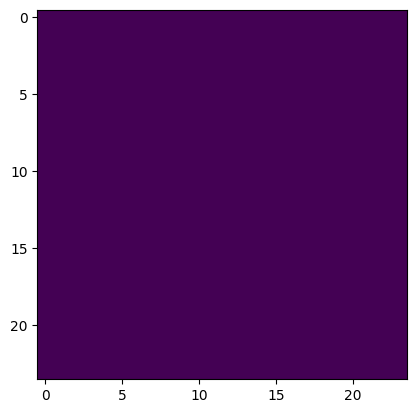

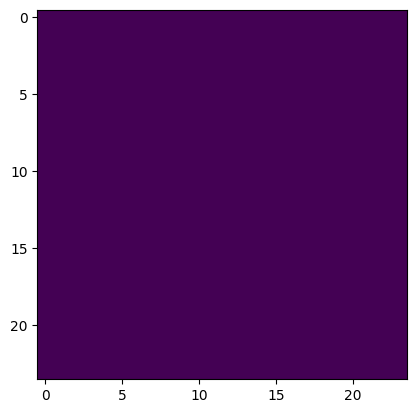

In [47]:
import matplotlib.pyplot as plt



result = dropblock(torch.ones((1,1,24, 24)))
plt.imshow(result[0][0].detach().cpu().numpy())
plt.show()

dropblock.eval()
result = dropblock(torch.ones((1,1,24, 24)))
plt.imshow(result[0][0].detach().cpu().numpy()*255.)
plt.show()

In [40]:
result[0][0].detach().cpu().numpy()

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 